In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers

from modules.dataset import OneHotProtDataset, AntibodyOneHotProtDataset
from modules.layers import SamplingLayer
from sklearn.model_selection import train_test_split

from modules.models.VAE import VAE

import matplotlib.pyplot as plt

In [3]:
x_data, y_data, vector_size, alphabet_size = AntibodyOneHotProtDataset.get_data(200)
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

### Encoder

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(vector_size, alphabet_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = SamplingLayer()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

2024-03-23 23:33:41.031040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 22, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 11, 32)          320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 50, 6, 64)            18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 19200)                0         ['conv2d_1[0][0]']            


2024-03-23 23:33:41.036057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 23:33:41.038921: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 23:33:41.043272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

                                                                                                  
 dense (Dense)               (None, 16)                   307216    ['flatten[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 2)                    34        ['dense[0][0]']               
                                                                                                  
 z_log_var (Dense)           (None, 2)                    34        ['dense[0][0]']               
                                                                                                  
 sampling_layer (SamplingLa  (None, 2)                    0         ['z_mean[0][0]',              
 yer)                                                                'z_log_var[0][0]']           
                                                                                                  
Total para

### Decoder

In [5]:
# Define decoder model. should have output shape (vector_size, alphabet_size, 1)

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(vector_size // 2 * alphabet_size // 2 * 64, activation="relu")(inputs)
x       = layers.Reshape((vector_size // 2, alphabet_size // 2, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
# x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 70400)             211200    
                                                                 
 reshape (Reshape)           (None, 100, 11, 64)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 100, 11, 64)       36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 200, 22, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 200, 22, 1)        577 

## Train the VAE

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
dataset = np.concatenate([x_train, x_test], axis=0)

In [15]:
%%time
vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(dataset, epochs=150, batch_size=128)


Epoch 1/150
13/13 [==============================] - 3s 55ms/step - loss: 478.7446 - reconstruction_loss: 458.1842 - kl_loss: 11.3074
Epoch 2/150
13/13 [==============================] - 1s 48ms/step - loss: 427.9909 - reconstruction_loss: 408.1851 - kl_loss: 11.1079
Epoch 3/150
13/13 [==============================] - 1s 48ms/step - loss: 412.2861 - reconstruction_loss: 397.8404 - kl_loss: 11.1670
Epoch 4/150
13/13 [==============================] - 1s 49ms/step - loss: 411.7070 - reconstruction_loss: 392.4490 - kl_loss: 11.2889
Epoch 5/150
13/13 [==============================] - 1s 48ms/step - loss: 410.6212 - reconstruction_loss: 389.1680 - kl_loss: 11.4760
Epoch 6/150
13/13 [==============================] - 1s 48ms/step - loss: 398.8447 - reconstruction_loss: 390.2209 - kl_loss: 11.4860
Epoch 7/150
13/13 [==============================] - 1s 48ms/step - loss: 401.1698 - reconstruction_loss: 391.7258 - kl_loss: 11.5655
Epoch 8/150
13/13 [==============================] - 1s 49ms/s

In [16]:
vae.save(f'run/vae-one-hot-{vector_size}.keras')

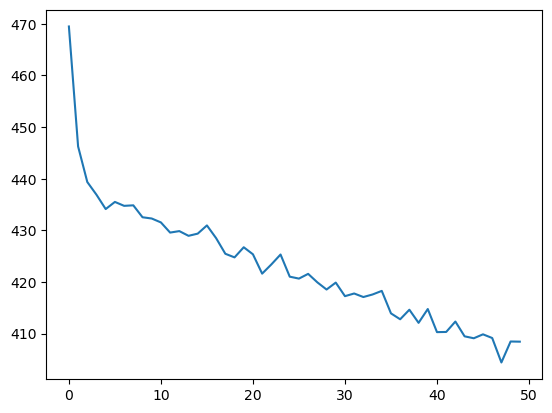

In [14]:
plt.figure()
plt.plot(history.history["loss"])

## References

- <https://keras.io/examples/generative/vae/>